In [1]:
import os
import numpy as np
from niiutility import loadallnii

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Loading the Image and Label
* using (nibabel)[https://nipy.org/nibabel/nibabel_images.html]
* the data path is img_xx
* the label path is bv_bodyxx

In [2]:
temp = loadnii(0)
show_image (*temp)

NameError: name 'loadnii' is not defined

# 2. Data Fixing
* reshape imgs into 192*256*256
* drop out bad inputs

image index: 0


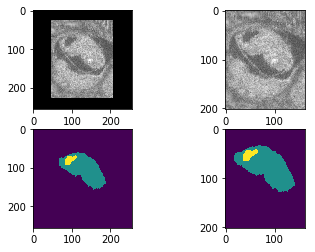

image index: 1


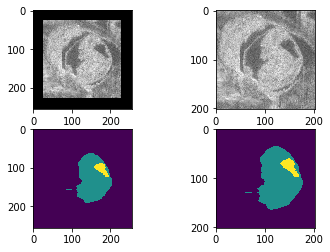

KeyboardInterrupt: 

In [3]:
%reload_ext autoreload
bad_index = np.array([46, 49, 65, 66, 81, 82, 97, 106])
image, label = loadallnii(107, bad_index, 192, 256, 256, verbose=True)

In [5]:
np.save('bv_body_data/predict/image.npy', image)
np.save('bv_body_data/predict/label.npy', label)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import torchvision.datasets as dset
import torchvision.transforms as T

from classifiers import *

USE_GPU = False

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
X, Y = loadnii(0)
X = zero_padding(X, 256, 256, 256)
Y = zero_padding(Y, 256, 256, 256)

show_image(X, Y)

X = X[::4,::4,::4]
Y = Y[::4,::4,::4]

X = (X - np.mean(X))/np.std(X)

X = X.reshape(1, 1, 64, 64, 64)
Y = Y.reshape(1, 64, 64, 64)

Xtr = torch.tensor(X)
Ytr = torch.tensor(Y)


In [ ]:
# testing FCN Net on a single image

from training import *
model = Dcon3D(64)
shape_test(model, device, dtype)

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print('first loss should be around ln3!')
overfit_test(model, device, dtype, optimizer, Xtr, Ytr, epochs=256)

In [ ]:
from vnet import *
from training import *

# testing VNet on a single image

learning_rate = 1e-3
model2 = VNet(classnum=3)
shape_test(model2, device, dtype)
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
print('first loss should be around ln3!')
overfit_test(model2, device, dtype, optimizer, Xtr, Ytr, epochs=256)

In [ ]:
def overfit_show(model, x, y):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        
        scoresTorch = model(x)
        scores = scoresTorch.numpy()
        scores = scores.reshape(3, 64, 64, 64)
        label = y.numpy()
        label = label.reshape(64, 64, 64)
         
        class0map = scores[0]
        class1map = scores[1]
        class2map = scores[2]
        
        min0 = np.amin(class0map)
        max0= np.amax(class0map)
        
        min1 = np.amin(class1map)
        max1= np.amax(class1map)
        
        min2 = np.amin(class2map)
        max2= np.amax(class2map)
        
        class0map = (class0map - min0)/(max0-min0)
        class1map = (class1map - min1)/(max1-min1)
        class2map = (class2map - min2)/(max2-min2)
        
        fig, ax = plt.subplots(1,4)

        slicing_index = 32

        ax[0].imshow(class0map[slicing_index], cmap='gray')
        ax[1].imshow(class1map[slicing_index], cmap='gray')
        ax[2].imshow(class2map[slicing_index], cmap='gray')
        ax[3].imshow(label[slicing_index])
        
        plt.show()
        

In [ ]:
overfit_show(model, Xtr, Ytr)

In [ ]:
from vnet import *

def shape_test(model):
    x = torch.zeros((1, 1, 32, 32, 32), dtype=dtype)
    scores = model(x)
    print(scores.size())

shape_vnet = VNet(3)
shape_test(shape_vnet, device)